In [62]:
%pip install mne scipy numpy matplotlib numba scikit-learn mat73 pandas --quiet

Note: you may need to restart the kernel to use updated packages.


# Software implementation of machine learning to determine biomarkers of Parkinson's disease using EEG

Using dataset: https://bit.ly/3pP1pts

(dataset is a public dataset (Anjum et al., 2020) recorded by the University of Iowa (UI; Iowa City, Iowa))

In [63]:
import os
import mne
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score
import mat73 # поддержка загрузки функций матлаба 7.3

# Exploratory Data Analysis


The data is a set of labeled (Control, PD) electroencephalograms, the dataset is balanced (14 Control people and 14 PD people).
Each copy has 63 channels.

### 1.1 Data Loading

Control group (no Parkinson disease)

In [30]:
raw_c = mne.io.read_raw_brainvision(vhdr_fname='./data/raw/IowaDataset/RawData/Control1021.vhdr')

Extracting parameters from ./data/raw/IowaDataset/RawData/Control1021.vhdr...
Setting channel info structure...


/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_27792/889979188.py:1: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw_c = mne.io.read_raw_brainvision(vhdr_fname='./data/raw/IowaDataset/RawData/Control1021.vhdr')


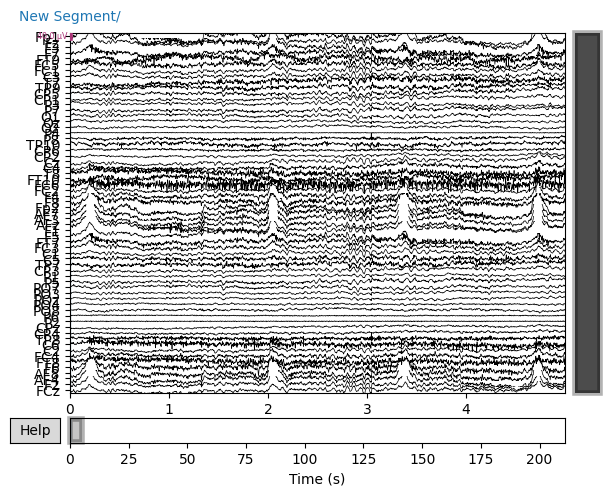

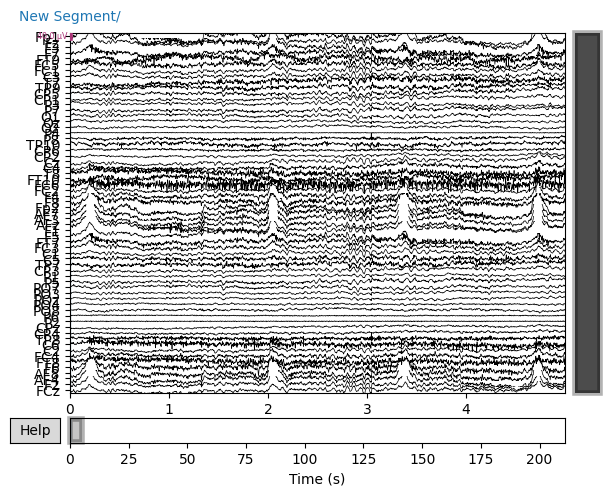

In [32]:
#raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw_c.plot(duration=5, n_channels=63)

With Parkinson disease:

In [33]:
raw_p = mne.io.read_raw_brainvision(vhdr_fname='./data/raw/IowaDataset/RawData/PD1001.vhdr')

Extracting parameters from ./data/raw/IowaDataset/RawData/PD1001.vhdr...
Setting channel info structure...


/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_27792/1241543869.py:1: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw_p = mne.io.read_raw_brainvision(vhdr_fname='./data/raw/IowaDataset/RawData/PD1001.vhdr')


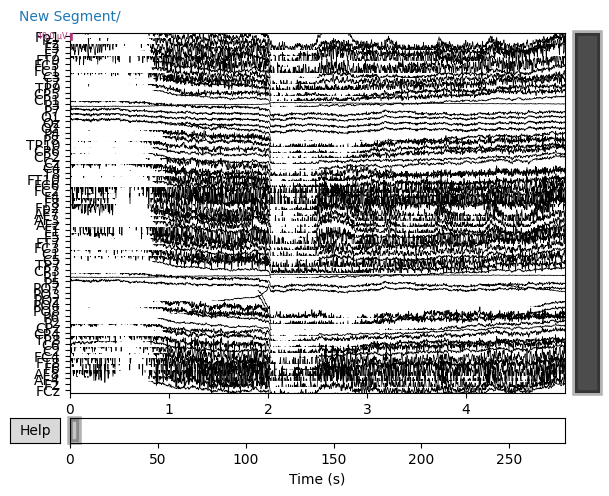

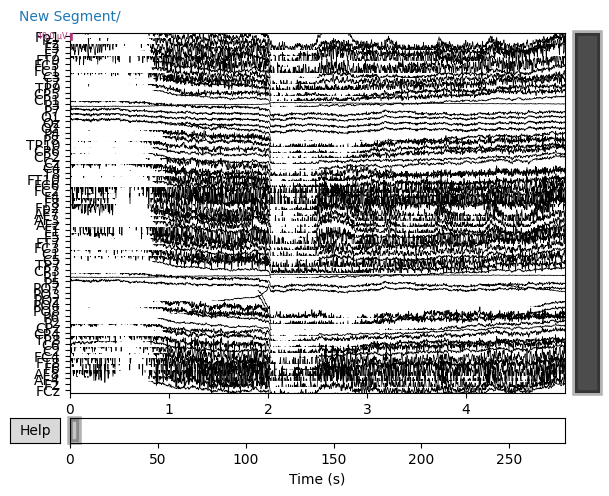

In [35]:
raw_p.plot(duration=5, n_channels=63)

As you can see, these examples visually are quite different

In [42]:
# split into 60 seconds parts
raw_c.crop(tmax=60)

<RawBrainVision | Control1021.eeg, 63 x 30001 (60.0 s), ~92 kB, data not loaded>

In [43]:
n_time_samps = raw_c.n_times
time_secs = raw_c.times
ch_names = raw_c.ch_names
n_chan = len(ch_names)  # note: there is no raw.n_channels attribute
print(
    f"the (cropped) sample data object has {n_time_samps} time samples and "
    f"{n_chan} channels."
)
print(f"The last time sample is at {time_secs[-1]} seconds.")
print("The first few channel names are {}.".format(", ".join(ch_names[:3])))
print()  # insert a blank line in the output

# some examples of raw.info:
print("bad channels:", raw_c.info["bads"])  # chs marked "bad" during acquisition
print(raw_c.info["sfreq"], "Hz")  # sampling frequency
print(raw_c.info["description"], "\n")  # miscellaneous acquisition info

print(raw_c.info)

the (cropped) sample data object has 30001 time samples and 63 channels.
The last time sample is at 60.0 seconds.
The first few channel names are Fp1, Fz, F3.

bad channels: []
500.0 Hz
None 

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 63 items (63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2018-01-02 11:44:36 UTC
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>


In [ ]:
events = mne.find_events(raw_c, stim_channel="Fp1")
events

array([], shape=(0, 3), dtype=int32)

In [50]:
events = mne.find_events(raw_p, stim_channel="P7")
events

array([], shape=(0, 3), dtype=int32)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components


/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/utils/check.py:88: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/utils/check.py:88: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fitting ICA took 9.0s.
    Using multitaper spectrum estimation with 7 DPSS windows


/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


Not setting metadata
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


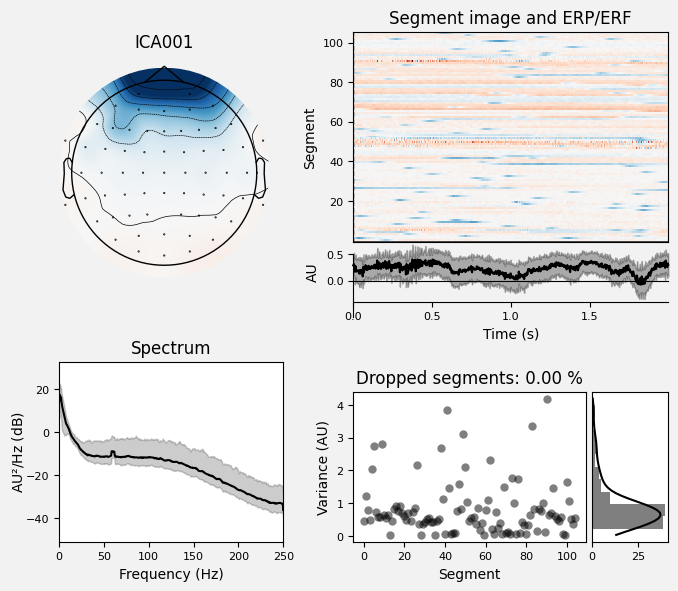

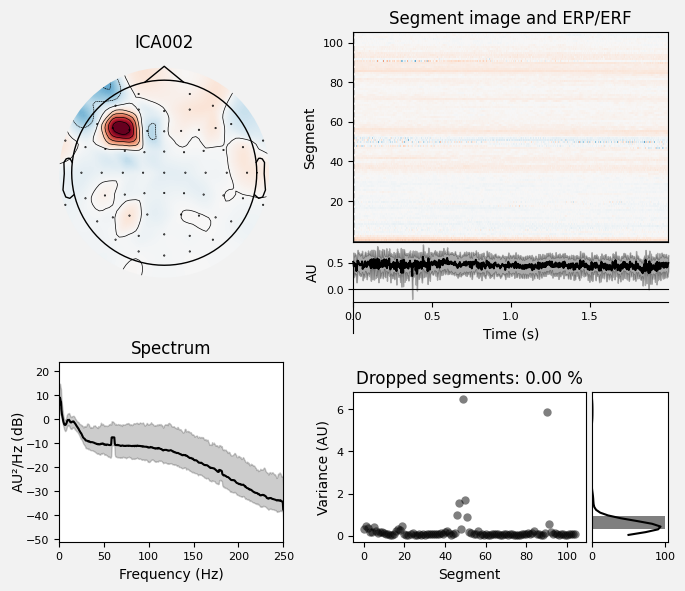

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [51]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw_c)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Fitting ICA to data using 63 channels (please be patient, this may take a while)


/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/utils/check.py:88: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/utils/check.py:88: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 20 components
Fitting ICA took 17.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


Not setting metadata
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/evakhromeeva/Projects/BeSMPSegmentation/.conda/lib/python3.9/site-packages/mne/viz/topomap.py:933: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


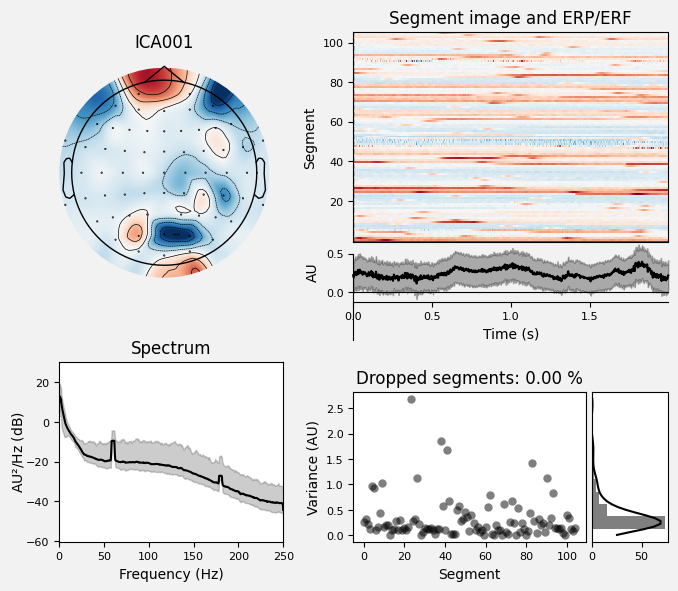

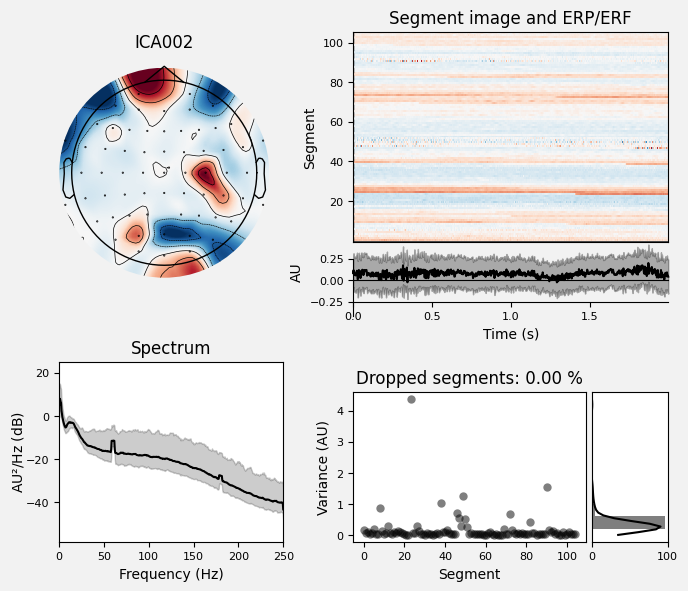

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [52]:
# set up and fit the ICA
ica_p = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica_p.fit(raw_p)
ica_p.exclude = [1, 2]  # details on how we picked these are omitted here
ica_p.plot_properties(raw, picks=ica.exclude)

### 1.2 Joining data to a dataset

In [55]:
path = './data/raw/IowaDataset/RawData'

In [56]:
def get_file_extension(img_path, img):
      if os.path.splitext(os.path.basename(os.path.join(img_path, img)))[1]:
            return os.path.splitext(os.path.basename(os.path.join(img_path, img)))[1]
      return ''

In [58]:
def get_file_name(img_path, img, file_extension = ".vhdr"):
    return os.path.splitext(os.path.basename(os.path.join(img_path, img)))[0]

In [59]:
def is_control(filename = ''):
    return filename.startswith('Control')

In [130]:
# Filenames we need to load
ids = os.listdir(path)
ids = [i for i in ids if get_file_extension(path, i,) == '.vhdr']
print(ids)


['PD1201.vhdr', 'Control1111.vhdr', 'Control1081.vhdr', 'PD1061.vhdr', 'Control1351.vhdr', 'PD1021.vhdr', 'PD1261.vhdr', 'PD1001.vhdr', 'PD1661.vhdr', 'Control1101.vhdr', 'PD1251.vhdr', 'PD1031.vhdr', 'Control1291.vhdr', 'PD1681.vhdr', 'Control1231.vhdr', 'PD1101.vhdr', 'PD1091.vhdr', 'Control1381.vhdr', 'PD1571.vhdr', 'Control1211.vhdr', 'Control1021.vhdr', 'PD1311.vhdr', 'PD1151.vhdr', 'Control1191.vhdr', 'Control1411.vhdr', 'Control1041.vhdr', 'Control1201.vhdr', 'Control1061.vhdr']


In [125]:
# TODO!!!
def create_dataset_item(filename, tmax=60):
    x_raw = mne.io.read_raw_brainvision(vhdr_fname=f'./data/raw/IowaDataset/RawData/{filename}').copy().crop(tmax=tmax)
    # print(x_raw.info)
    #x_train = ...
    y_item = np.array([0]) if is_control(filename) else np.array([1])
    return (x_raw, y_item)


In [129]:
tstp_x, tstp_y = create_dataset_item('PD1661.vhdr')
tstc_x, tstc_y = create_dataset_item('Control1081.vhdr')

print(tstc_y)
print(tstp_y)

Extracting parameters from ./data/raw/IowaDataset/RawData/PD1661.vhdr...
Setting channel info structure...
Extracting parameters from ./data/raw/IowaDataset/RawData/Control1081.vhdr...
Setting channel info structure...
[0]
[1]


/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_27792/2237792071.py:3: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  x_raw = mne.io.read_raw_brainvision(vhdr_fname=f'./data/raw/IowaDataset/RawData/{filename}').copy().crop(tmax=tmax)
/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_27792/2237792071.py:3: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  x_raw = mne.io.read_raw_brainvision(vhdr_fname=f'./data/raw/IowaDataset/RawData/{filename}').copy().crop(tmax=tmax)


In [ ]:
x_train = np.array([])
y_train = np.array([])
for i in range(len(ids)):
    x, y = create_dataset_item(ids[i], 60)
    #print(np.ndim(x[0][0]))
    #print(x[62][0][0][30000])

Методом тыка выяснили:
1. x[0] - это каналы, изменяются от 0 до 62
2. x[0][0] - изменяется от 0 до 1, непонятно, что это такое - вероятно, какой-то другой срез по тем же каналам
3. x[0][0][0] - вообще просто число, которое убрано в массив. Видимо, транспонировали что-то. Может быть только 0.
4. x[0][0][0] - от 0 до 30000 (30001 значение) - Это размерность времени (60 сек)